# Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, RocCurveDisplay, brier_score_loss
)
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV

# Extração dos dados

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/xG/"

X_train = pd.read_csv(path + "X_train_.csv")
X_test  = pd.read_csv(path + "X_test_.csv")
y_train = pd.read_csv(path + "y_train.csv").values.ravel()
y_test  = pd.read_csv(path + "y_test.csv").values.ravel()
xg = pd.read_csv(path + 'X_baseline.csv')
xg_baseline = xg.loc[X_test.index]
xg_baseline = xg_baseline['shot_statsbomb_xg'].values

# Funções Auxiliares

In [ ]:
def result(X_test, model):

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    brier = brier_score_loss(y_test, y_prob)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nBrier Score: ", round(brier, 4))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title("Curva ROC")
    plt.show()

    plt.figure(figsize=(10,5))
    sns.histplot(y_prob, color='blue', kde=True, stat='density', label='KNN (xG)')
    sns.histplot(xg_baseline, color='red', kde=True, stat='density', label='StatsBomb (xG)')
    plt.title("Distribuição das Probabilidades (Teste)")
    plt.xlabel("xG Predito")
    plt.legend()
    plt.show()

    plt.hist(y_prob, bins=100)
    plt.show()

    print("Min", np.min(y_prob))
    print("Max", np.max(y_prob))
    print("Mean", np.mean(y_prob))

# Treinamento 1 - Modelo Base

In [ ]:
knn = KNeighborsClassifier(weights='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1400
           1       0.47      0.24      0.32       167

    accuracy                           0.89      1567
   macro avg       0.69      0.60      0.63      1567
weighted avg       0.87      0.89      0.87      1567


Brier Score:  0.0897


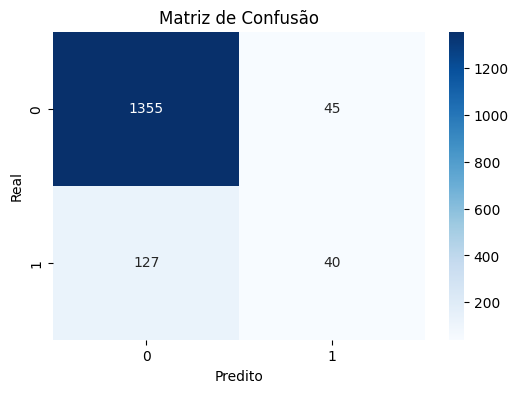

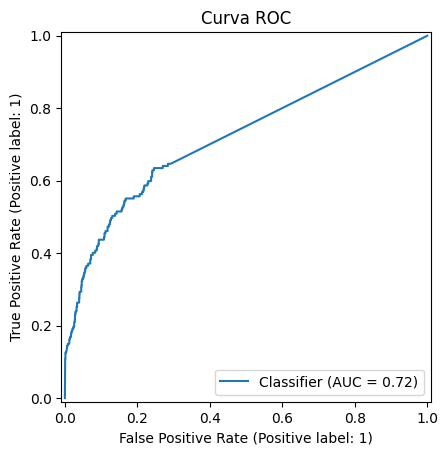

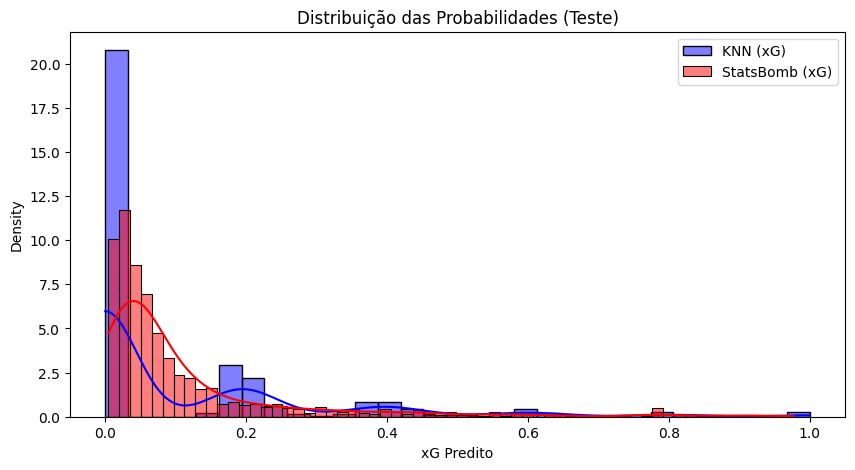

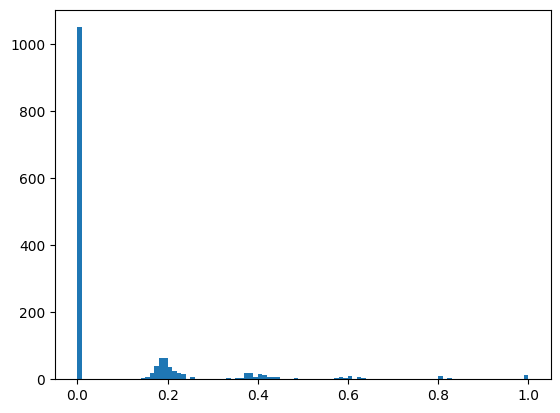

Min 0.0
Max 1.0
Mean 0.10926356037736971


In [ ]:
result(X_test, knn)

# Treinamento 2 - Modelo Base + PCA

# Treinamento 3 - Otimização de Hiperparâmetros

In [ ]:
def evaluate_knn_for_n(X_train, y_train, X_test, y_test, n):

    model = KNeighborsClassifier(
        n_neighbors=n,
        weights="distance"  # recomendado para xG
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return {
        "n_neighbors": n,
        "accuracy": accuracy_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_prob),
        "recall": recall_score(y_test, y_pred),
        "brier": brier_score_loss(y_test, y_prob)
    }


In [ ]:
n_values = range(2, 1000, 1)
resultados = []

for n in n_values:
    metrics = evaluate_knn_for_n(
        X_train, y_train,
        X_test, y_test,
        n
    )
    resultados.append(metrics)

results_df = pd.DataFrame(resultados)
results_df

,n_neighbors,accuracy,auc,recall,brier
0,2,0.864710,0.683743,0.359281,0.105466
1,3,0.881940,0.702780,0.287425,0.098651
2,4,0.886407,0.716146,0.293413,0.092256
3,5,0.890236,0.720624,0.239521,0.089680
4,6,0.889598,0.733084,0.239521,0.086762
...,...,...,...,...,...
993,995,0.898532,0.800943,0.071856,0.081676
994,996,0.898532,0.801029,0.071856,0.081674
995,997,0.898532,0.801029,0.071856,0.081676
996,998,0.898532,0.801037,0.071856,0.081674


In [ ]:
best_row = results_df.loc[results_df["brier"].idxmin()]

best_n = int(best_row["n_neighbors"])
best_metrics = best_row.to_dict()

print("Melhor N (Brier mínimo):", best_n)
print("Métricas associadas:")
best_metrics

Melhor N (Brier mínimo): 76
Métricas associadas:


{'n_neighbors': 76.0,
 'accuracy': 0.9029993618379069,
 'auc': 0.8039927288280583,
 'recall': 0.15568862275449102,
 'brier': 0.07742809379607618}

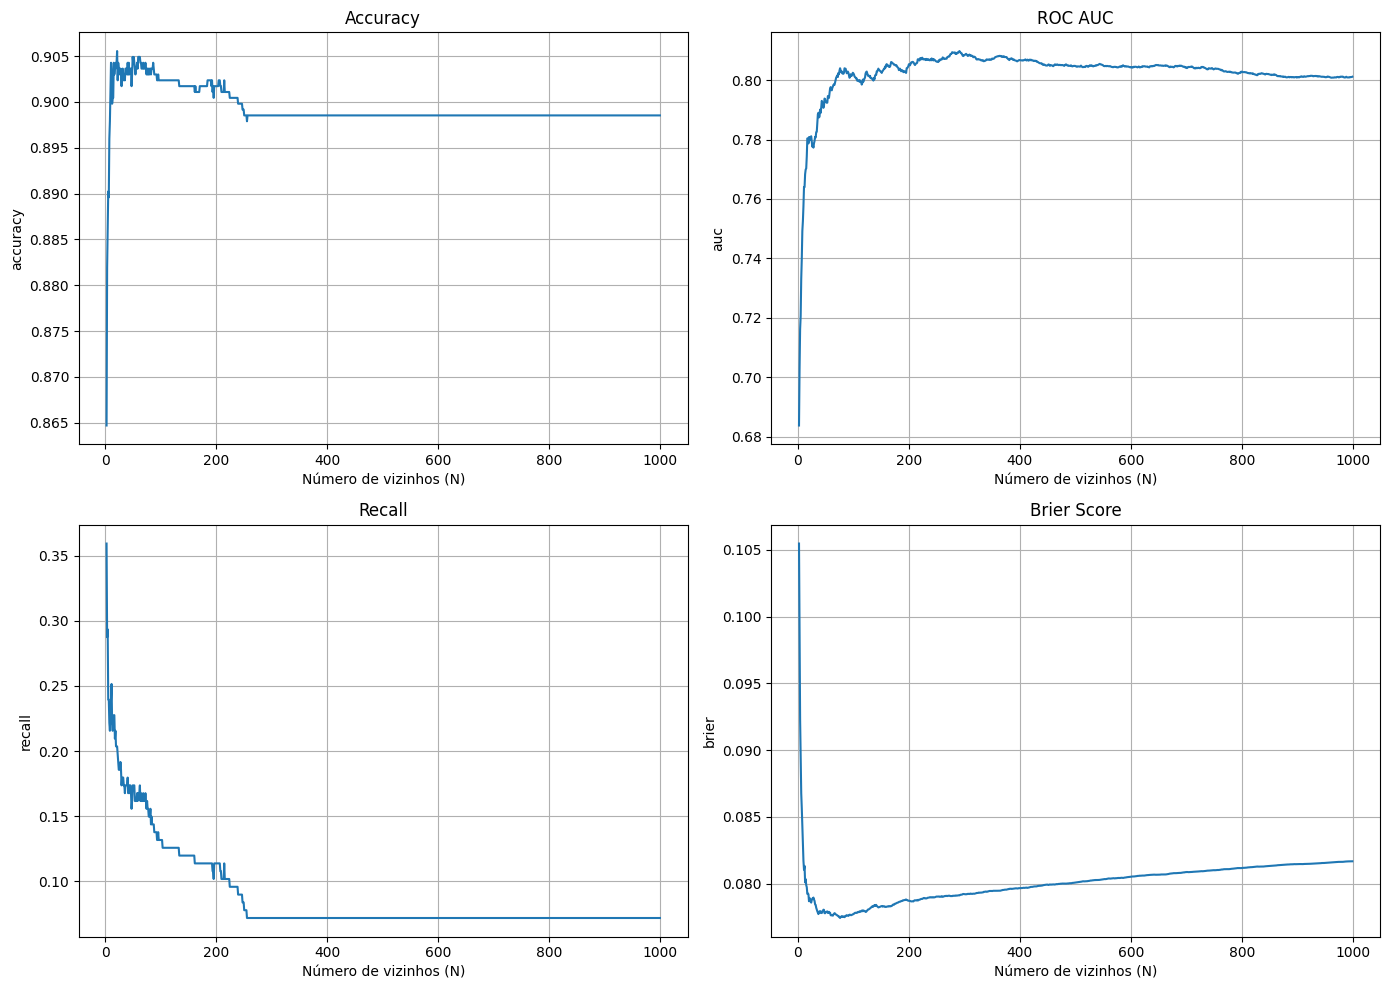

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = [
    ("accuracy", "Accuracy"),
    ("auc", "ROC AUC"),
    ("recall", "Recall"),
    ("brier", "Brier Score")
]

for ax, (col, title) in zip(axes.flatten(), metrics):
    ax.plot(results_df["n_neighbors"], results_df[col])
    ax.set_title(title)
    ax.set_xlabel("Número de vizinhos (N)")
    ax.set_ylabel(col)
    ax.grid(True)

plt.tight_layout()
plt.show()


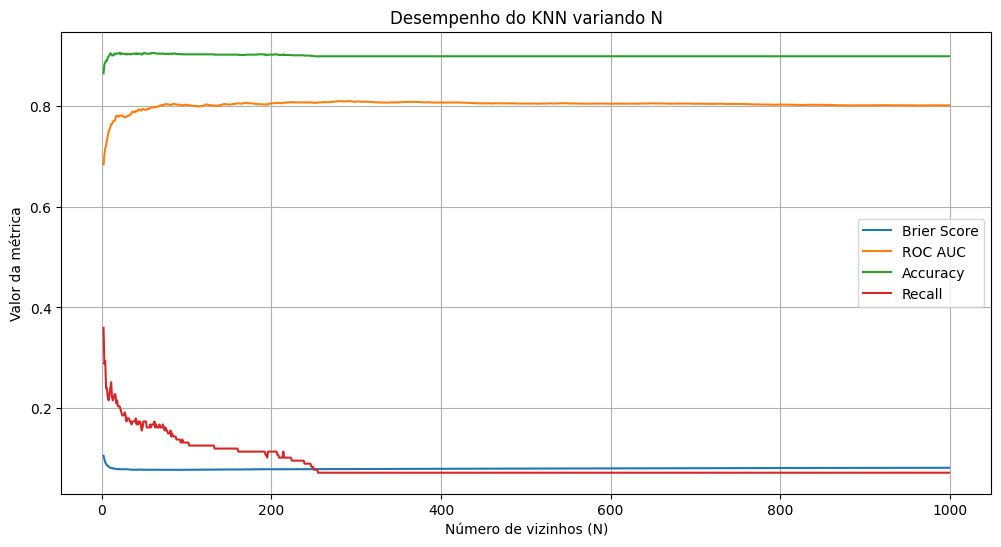

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(results_df["n_neighbors"], results_df["brier"], label="Brier Score")
plt.plot(results_df["n_neighbors"], results_df["auc"], label="ROC AUC")
plt.plot(results_df["n_neighbors"], results_df["accuracy"], label="Accuracy")
plt.plot(results_df["n_neighbors"], results_df["recall"], label="Recall")

plt.xlabel("Número de vizinhos (N)")
plt.ylabel("Valor da métrica")
plt.title("Desempenho do KNN variando N")
plt.legend()
plt.grid(True)
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1400
           1       0.70      0.16      0.25       167

    accuracy                           0.90      1567
   macro avg       0.81      0.57      0.60      1567
weighted avg       0.89      0.90      0.87      1567


Brier Score:  0.0774


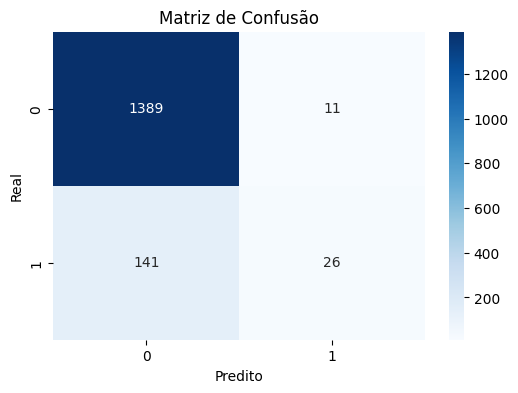

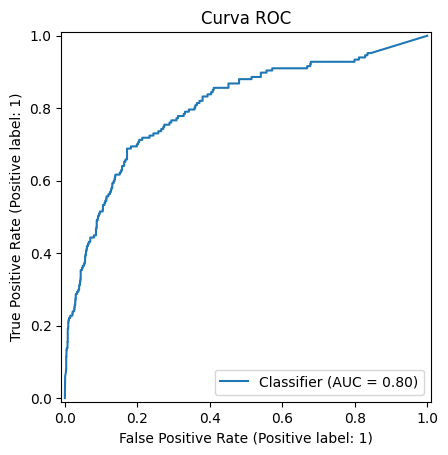

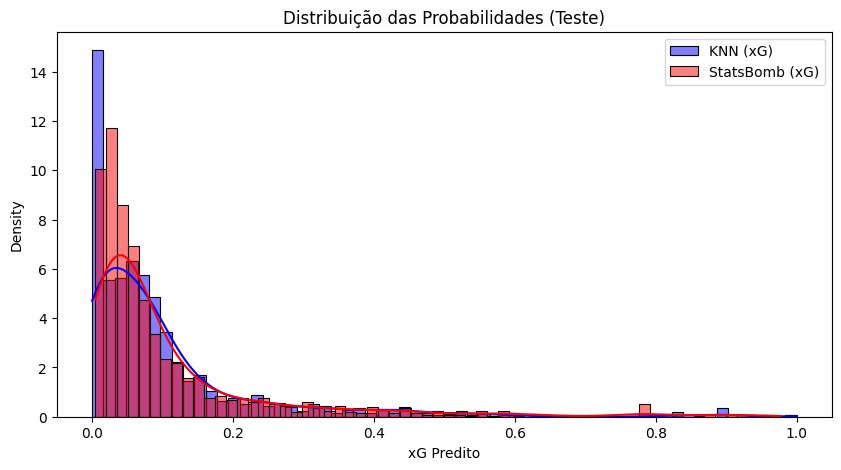

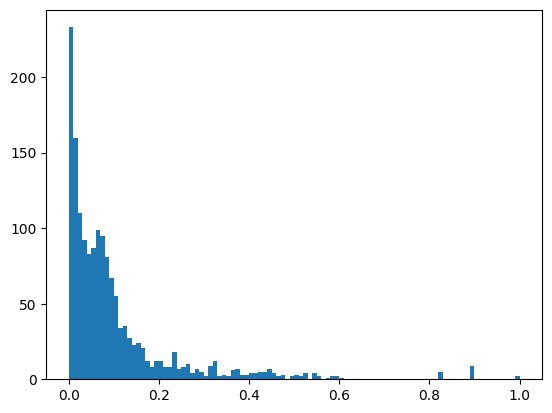

Min 0.0
Max 1.0
Mean 0.10024454905037958


In [ ]:
knn = KNeighborsClassifier(n_neighbors=76, weights='distance')
knn.fit(X_train, y_train)
result(X_test, knn)

# Treinamento 4 - Otimização de Hiperparâmetros + PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def evaluate_knn_pca(
    X_train, y_train,
    X_test, y_test,
    n_neighbors,
    n_components
):

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca  = pca.transform(X_test_scaled)

    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights="distance"
    )

    model.fit(X_train_pca, y_train)

    y_pred = model.predict(X_test_pca)
    y_prob = model.predict_proba(X_test_pca)[:, 1]

    return {
        "n_neighbors": n_neighbors,
        "n_components": n_components,
        "accuracy": accuracy_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_prob),
        "recall": recall_score(y_test, y_pred),
        "brier": brier_score_loss(y_test, y_prob)
    }


In [ ]:
results = []

max_components = X_train.shape[1]

for n in range(2, 400, 1):
    for k in [2, 5, 7, 10, 14, 17, 20, 23, 27]:
        print(f"N = {n} | K = {k}")
        results.append(
            evaluate_knn_pca(
                X_train, y_train,
                X_test, y_test,
                n_neighbors=n,
                n_components=k
            )
        )

results_pca_df = pd.DataFrame(results)


N = 2 | K = 2
N = 2 | K = 5
N = 2 | K = 7
N = 2 | K = 10
N = 2 | K = 14
N = 2 | K = 17
N = 2 | K = 20
N = 2 | K = 23
N = 2 | K = 27
N = 3 | K = 2
N = 3 | K = 5
N = 3 | K = 7
N = 3 | K = 10
N = 3 | K = 14
N = 3 | K = 17
N = 3 | K = 20
N = 3 | K = 23
N = 3 | K = 27
N = 4 | K = 2
N = 4 | K = 5
N = 4 | K = 7
N = 4 | K = 10
N = 4 | K = 14
N = 4 | K = 17
N = 4 | K = 20
N = 4 | K = 23
N = 4 | K = 27
N = 5 | K = 2
N = 5 | K = 5
N = 5 | K = 7
N = 5 | K = 10
N = 5 | K = 14
N = 5 | K = 17
N = 5 | K = 20
N = 5 | K = 23
N = 5 | K = 27
N = 6 | K = 2
N = 6 | K = 5
N = 6 | K = 7
N = 6 | K = 10
N = 6 | K = 14
N = 6 | K = 17
N = 6 | K = 20
N = 6 | K = 23
N = 6 | K = 27
N = 7 | K = 2
N = 7 | K = 5
N = 7 | K = 7
N = 7 | K = 10
N = 7 | K = 14
N = 7 | K = 17
N = 7 | K = 20
N = 7 | K = 23
N = 7 | K = 27
N = 8 | K = 2
N = 8 | K = 5
N = 8 | K = 7
N = 8 | K = 10
N = 8 | K = 14
N = 8 | K = 17
N = 8 | K = 20
N = 8 | K = 23
N = 8 | K = 27
N = 9 | K = 2
N = 9 | K = 5
N = 9 | K = 7
N = 9 | K = 10
N = 9 | K = 14
N = 

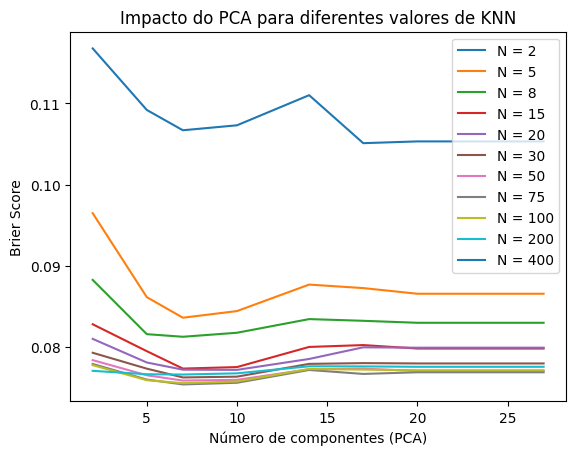

In [ ]:
ks = [2, 5, 8, 15, 20, 30, 50, 75, 100, 200, 400]

plt.figure()

for k in ks:
    subset = results_pca_df[results_pca_df["n_neighbors"] == k]
    plt.plot(subset["n_components"], subset["brier"], label=f"N = {k}")

plt.xlabel("Número de componentes (PCA)")
plt.ylabel("Brier Score")
plt.title("Impacto do PCA para diferentes valores de KNN")
plt.legend()
plt.show()



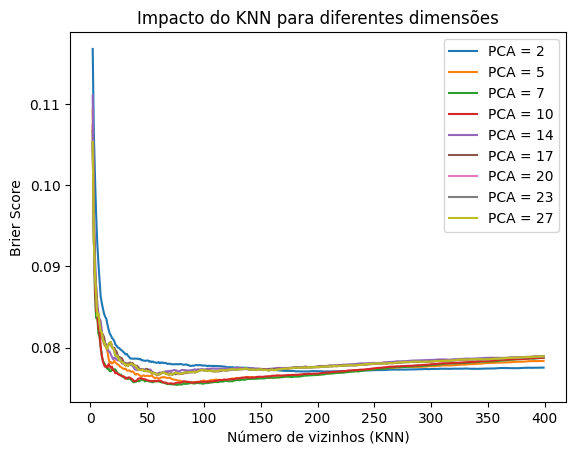

In [ ]:
pcs = [2, 5, 7, 10, 14, 17, 20, 23, 27]

plt.figure()

for pc in pcs:
    subset = results_pca_df[results_pca_df["n_components"] == pc]
    plt.plot(subset["n_neighbors"], subset["brier"], label=f"PCA = {pc}")

plt.xlabel("Número de vizinhos (KNN)")
plt.ylabel("Brier Score")
plt.title("Impacto do KNN para diferentes dimensões")
plt.legend()
plt.show()


In [ ]:
best_row = results_pca_df.loc[results_pca_df["brier"].idxmin()]
best_row

,677
n_neighbors,77.000000
n_components,7.000000
accuracy,0.901723
auc,0.815554
recall,0.179641
brier,0.075403


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

model = KNeighborsClassifier(
    n_neighbors=77,
    weights="distance"
)

model.fit(X_train_pca, y_train)

KNeighborsClassifier(n_neighbors=77, weights='distance')


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1400
           1       0.64      0.18      0.28       167

    accuracy                           0.90      1567
   macro avg       0.77      0.58      0.61      1567
weighted avg       0.88      0.90      0.88      1567


Brier Score:  0.0754


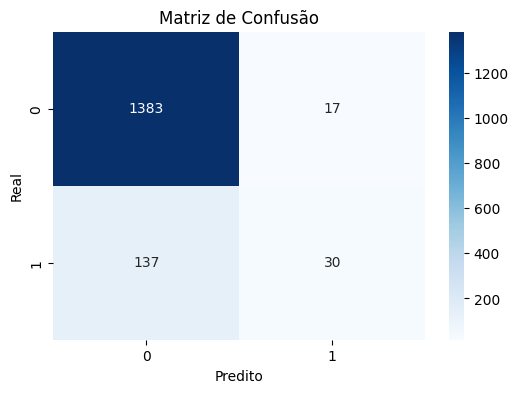

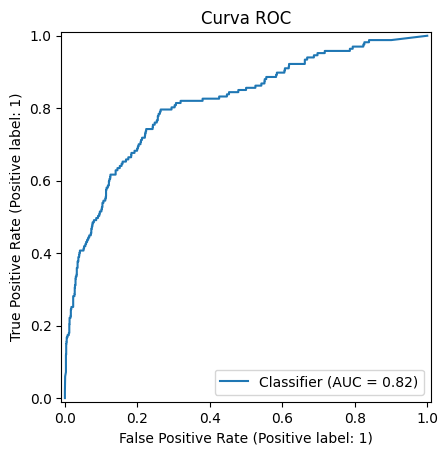

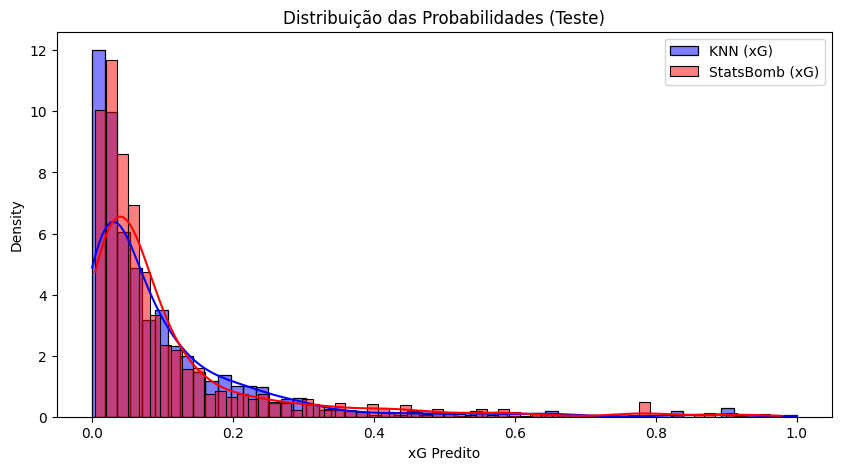

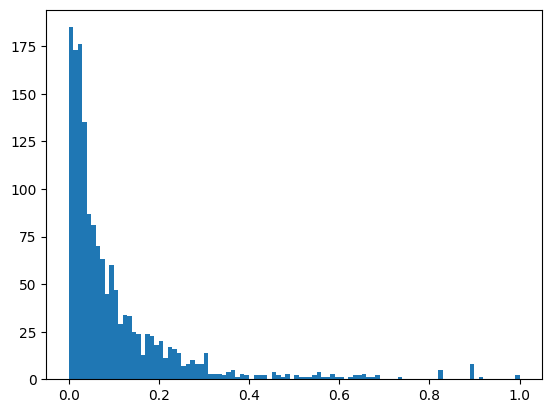

Min 0.0
Max 1.0
Mean 0.10183955676827153


In [ ]:
result(X_test_pca, model)